In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import shutil
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import  ReduceLROnPlateau, EarlyStopping

In [2]:
# Transfering the variables from the preprocessing notebook
%store -r train_dir
%store -r val_dir
%store -r test_dir
%store -r val_datagen
%store -r test_datagen

In [3]:
# A basic rescaling for the preparation of the images
train_datagen = ImageDataGenerator(
    rescale = 1./255.)

Setting input size, batch size and class mode for ever generator

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    batch_size = 20,
    target_size = (224, 224),
    class_mode = 'categorical')

Found 17510 images belonging to 5 classes.


In [5]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    batch_size = 20,
    target_size = (224, 224),
    class_mode = 'categorical')

Found 5025 images belonging to 5 classes.


In [6]:
test_generator = test_datagen.flow_from_directory(
    directory = test_dir,
    batch_size = 2,
    target_size = (224, 224),
    class_mode = None,
    shuffle = False)

Found 2465 images belonging to 5 classes.


In [7]:
# Starting a sequential model
model = Sequential()

2021-09-03 12:50:54.852602: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Adding 2 pairs of convolution and pooling layers

In [8]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))

In [9]:
model.add(MaxPooling2D((2, 2)))

In [10]:
model.add(Conv2D(64, (3, 3), activation='relu'))

In [11]:
model.add(MaxPooling2D((2, 2)))

An MLP structure was added to display the desired outputs in 1d format

In [12]:
model.add(Dropout(0.25))

In [13]:
model.add(Flatten())

In [14]:
model.add(Dense(1024, activation='relu'))

In [15]:
model.add(Dropout(0.25))

In [16]:
model.add(Dense(5, activation='softmax'))

In [17]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1

In [19]:
callbacks = [  
    # Stop training when val_loss has stopped improving
    EarlyStopping(monitor = 'val_loss',
                  patience = 3,
                  verbose = 1,
                  restore_best_weights = True),
    # Reduce learning rate when val_loss has stopped improving
    ReduceLROnPlateau(monitor = 'val_loss',
                      factor = 0.1,
                      patience = 3,
                      verbose = 1)
]

In [20]:
inc_history = model.fit(train_generator, validation_data = val_generator, steps_per_epoch = 20, epochs = 100, callbacks = callbacks)

2021-09-03 12:50:58.780932: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
20/20 [==============================] - 90s 4s/step - loss: 3.2971 - accuracy: 0.2850 - val_loss: 1.1243 - val_accuracy: 0.4314
Epoch 2/100
20/20 [==============================] - 88s 5s/step - loss: 1.1520 - accuracy: 0.4325 - val_loss: 0.8916 - val_accuracy: 0.5670
Epoch 3/100
20/20 [==============================] - 87s 4s/step - loss: 0.9061 - accuracy: 0.6325 - val_loss: 0.8044 - val_accuracy: 0.6657
Epoch 4/100
20/20 [==============================] - 89s 5s/step - loss: 0.8747 - accuracy: 0.5800 - val_loss: 0.7986 - val_accuracy: 0.6267
Epoch 5/100
20/20 [==============================] - 87s 5s/step - loss: 0.8494 - accuracy: 0.6375 - val_loss: 0.7130 - val_accuracy: 0.6669
Epoch 6/100
20/20 [==============================] - 88s 5s/step - loss: 0.8280 - accuracy: 0.6175 - val_loss: 0.7192 - val_accuracy: 0.6710
Epoch 7/100
20/20 [==============================] - 89s 5s/step - loss: 0.7376 - accuracy: 0.6500 - val_loss: 0.7138 - val_accuracy: 0.6943
Epoch 8/100
2

In [21]:
#Saving the model's weights and architecture
model.save('CNN-1.h5')

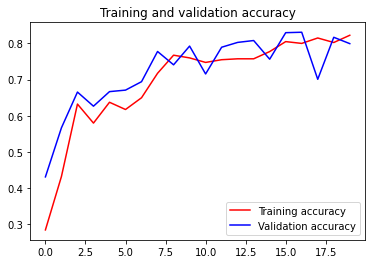

<Figure size 432x288 with 0 Axes>

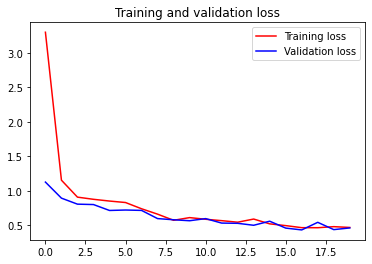

<Figure size 432x288 with 0 Axes>

In [22]:
#Plotting the metrics
import matplotlib.pyplot as plt

acc = inc_history.history['accuracy']
val_acc = inc_history.history['val_accuracy']
loss = inc_history.history['loss']
val_loss = inc_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

Preparing the inputs for the confusion matrix and classification report

In [23]:
pred_probs = model.predict(test_generator,verbose = 2)

1233/1233 - 76s


In [24]:
predicted_indices = np.argmax(pred_probs, axis=1)

In [25]:
# The predicted classes of the test set as an integer
predicted_indices

array([0, 0, 1, ..., 4, 4, 4])

In [26]:
# The default classes of the test directory as an integer
test_generator.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = test_generator.classes, y_pred = predicted_indices)

In [28]:
cm

array([[315, 174,   4,   0,   0],
       [ 25, 468,   0,   0,   0],
       [ 11,   2, 327,   0, 153],
       [  0,   2,  36, 455,   0],
       [  0,   0,  37,   0, 456]])

In [29]:
target_names = ["colon_aca","colon_n","lung_aca","lung_n","lung_scc",]

In [30]:
pd.DataFrame(cm,
             columns = target_names,
             index= target_names)

,colon_aca,colon_n,lung_aca,lung_n,lung_scc
colon_aca,315,174,4,0,0
colon_n,25,468,0,0,0
lung_aca,11,2,327,0,153
lung_n,0,2,36,455,0
lung_scc,0,0,37,0,456


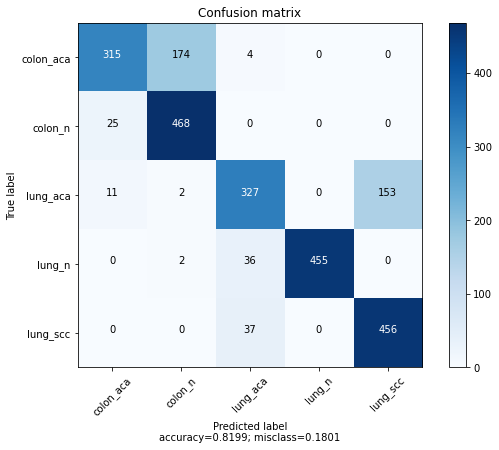

In [31]:
# Plotting a confusion matrix with extra features and a more analytical display
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
plot_confusion_matrix(cm,target_names)


In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_true = test_generator.classes, y_pred = predicted_indices, target_names = target_names))

              precision    recall  f1-score   support

   colon_aca       0.90      0.64      0.75       493
     colon_n       0.72      0.95      0.82       493
    lung_aca       0.81      0.66      0.73       493
      lung_n       1.00      0.92      0.96       493
    lung_scc       0.75      0.92      0.83       493

    accuracy                           0.82      2465
   macro avg       0.84      0.82      0.82      2465
weighted avg       0.84      0.82      0.82      2465



The comments for the commands will not be repeated in the second model since the parameters and the structure is the same

In [33]:
#Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True)

In [34]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    batch_size = 20,
    target_size = (224, 224),
    class_mode = 'categorical')

Found 17510 images belonging to 5 classes.


In [35]:
model2 = Sequential()

In [36]:
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))

In [37]:
model2.add(MaxPooling2D((2, 2)))

In [38]:
model2.add(Conv2D(64, (3, 3), activation='relu'))

In [39]:
model2.add(MaxPooling2D((2, 2)))

In [40]:
model2.add(Dropout(0.25))

In [41]:
model2.add(Flatten())

In [42]:
model2.add(Dense(1024, activation='relu'))

In [43]:
model2.add(Dropout(0.25))

In [44]:
model2.add(Dense(5, activation='softmax'))

In [45]:
model2.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [46]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)             

In [47]:
callbacks = [  
    EarlyStopping(monitor = 'val_loss',
                  patience = 3,
                  verbose = 1,
                  restore_best_weights = True),
    ReduceLROnPlateau(monitor = 'val_loss',
                      factor = 0.1,
                      patience = 3,
                      verbose = 1)
]

In [48]:
inc_history2 = model2.fit(train_generator, validation_data = val_generator, steps_per_epoch = 20, epochs = 100, callbacks = callbacks)

Epoch 1/100
20/20 [==============================] - 99s 5s/step - loss: 2.7235 - accuracy: 0.3225 - val_loss: 1.1652 - val_accuracy: 0.4400
Epoch 2/100
20/20 [==============================] - 96s 5s/step - loss: 1.0320 - accuracy: 0.5475 - val_loss: 0.8139 - val_accuracy: 0.6416
Epoch 3/100
20/20 [==============================] - 94s 5s/step - loss: 0.8380 - accuracy: 0.5900 - val_loss: 0.7108 - val_accuracy: 0.7190
Epoch 4/100
20/20 [==============================] - 92s 5s/step - loss: 0.7379 - accuracy: 0.6850 - val_loss: 0.6807 - val_accuracy: 0.7317
Epoch 5/100
20/20 [==============================] - 92s 5s/step - loss: 0.6995 - accuracy: 0.6875 - val_loss: 0.6051 - val_accuracy: 0.7453
Epoch 6/100
20/20 [==============================] - 94s 5s/step - loss: 0.6501 - accuracy: 0.6825 - val_loss: 0.7634 - val_accuracy: 0.5747
Epoch 7/100
20/20 [==============================] - 92s 5s/step - loss: 0.6986 - accuracy: 0.6775 - val_loss: 0.5694 - val_accuracy: 0.7608
Epoch 8/100
2

In [49]:
model2.save('CNN-2.h5')

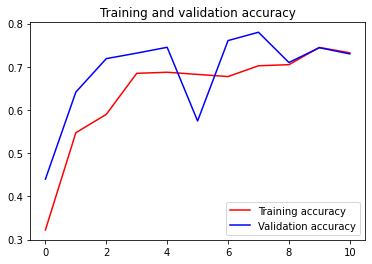

<Figure size 432x288 with 0 Axes>

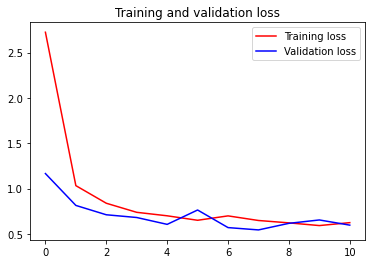

<Figure size 432x288 with 0 Axes>

In [50]:
import matplotlib.pyplot as plt

acc = inc_history2.history['accuracy']
val_acc = inc_history2.history['val_accuracy']
loss = inc_history2.history['loss']
val_loss = inc_history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

Preparing the inputs for the confusion matrix and classification report

In [51]:
pred_probs2 = model2.predict(test_generator,verbose = 2)

1233/1233 - 81s


In [52]:
predicted_indices2 = np.argmax(pred_probs2, axis=1)

In [53]:
predicted_indices2

array([0, 0, 1, ..., 4, 4, 4])

In [54]:
test_generator.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [55]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_true = test_generator.classes, y_pred = predicted_indices2)

In [56]:
cm2

array([[226, 264,   3,   0,   0],
       [ 13, 480,   0,   0,   0],
       [ 19,   4, 367,   4,  99],
       [  2,  21,  34, 436,   0],
       [  3,   0, 107,   0, 383]])

In [57]:
target_names = ["colon_aca","colon_n","lung_aca","lung_n","lung_scc",]

In [58]:
pd.DataFrame(cm2,
             columns = target_names,
             index= target_names)

,colon_aca,colon_n,lung_aca,lung_n,lung_scc
colon_aca,226,264,3,0,0
colon_n,13,480,0,0,0
lung_aca,19,4,367,4,99
lung_n,2,21,34,436,0
lung_scc,3,0,107,0,383


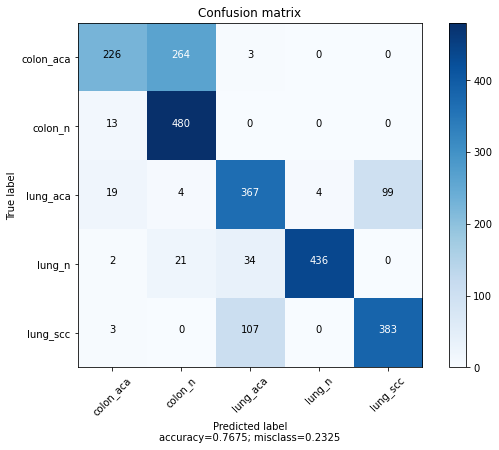

In [59]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
plot_confusion_matrix(cm2,target_names)


In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_true = test_generator.classes, y_pred = predicted_indices2, target_names = target_names))

              precision    recall  f1-score   support

   colon_aca       0.86      0.46      0.60       493
     colon_n       0.62      0.97      0.76       493
    lung_aca       0.72      0.74      0.73       493
      lung_n       0.99      0.88      0.93       493
    lung_scc       0.79      0.78      0.79       493

    accuracy                           0.77      2465
   macro avg       0.80      0.77      0.76      2465
weighted avg       0.80      0.77      0.76      2465

